# Deep Convolutional GANs

## Importing the libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

## Setting some hyperparameters

* We set the size of the batch.
* We set the size of the generated images (64x64).

In [2]:
batchSize = 64
imageSize = 64 

## Creating the transformations

* We create a list of transformations (scaling, tensor conversion, normalization) to apply to the input images.

In [3]:
transform = transforms.Compose(
    [transforms.Scale(imageSize),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),
                          (0.5, 0.5, 0.5))])

C:\Users\Ripti\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


## Loading the dataset

* We download the training set in the ./data folder and we apply the previous transformations on each image.
* We use dataLoader to get the images of the training set batch by batch.

In [4]:
dataset = dset.CIFAR10(
    root = './data', 
    download = True, 
    transform = transform)
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size = batchSize, 
    shuffle = True, 
    num_workers = 2)

Files already downloaded and verified


## Defining the weights_init function that takes as input a neural network m and that will initialize all its weights.

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

## Defining the generator

* We introduce a class to define the generator.
* We introduce the __init__() function that will define the architecture of the generator.
* We inherit from the nn.Module tools.
* We create a meta module of a neural network that will contain a sequence of modules (convolutions, full connections, etc.).
* We start with an inversed convolution.
* We normalize all the features along the dimension of the batch.
* We apply a ReLU rectification to break the linearity.
* We add another inversed convolution.
* We normalize again.
* We apply another ReLU.
* We add another inversed convolution.
* We normalize again.
* We apply another ReLU.
* We add another inversed convolution.
* We normalize again.
* We apply another ReLU.
* We add another inversed convolution.
* We apply a Tanh rectification to break the linearity and stay between -1 and +1.

### We define the forward function that takes as argument an input that will be fed to the neural network, and that will return the output containing the generated images.

* We forward propagate the signal through the whole neural network of the generator defined by self.main.
* We return the output containing the generated images.

In [6]:
class G(nn.Module):

    def __init__(self):
        super(G, self).__init__() 
        self.main = nn.Sequential( 
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(True), 
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False), 
            nn.BatchNorm2d(64),
            nn.ReLU(True), 
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False), 
            nn.Tanh() 
        )

    def forward(self, input): 
        output = self.main(input) 
        return output 

## Creating the generator

* We create the generator object.
* We initialize all the weights of its neural network.

In [7]:
netG = G()
netG.apply(weights_init)

G(
  (main): Sequential(
    (0): ConvTranspose2d (100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d (512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d (256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d (128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d (64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

## Defining the discriminator

* We introduce a class to define the discriminator.
* We introduce the __init__() function that will define the architecture of the discriminator.
* We inherit from the nn.Module tools.
* We create a meta module of a neural network that will contain a sequence of modules (convolutions, full connections, etc.).
* We start with a convolution.
* We apply a LeakyReLU.
* We add another convolution.
* We normalize all the features along the dimension of the batch.
* We apply another LeakyReLU.
* We add another convolution.
* We normalize again.
* We apply another LeakyReLU.
* We add another convolution.
* We normalize again.
* We apply another LeakyReLU.
* We add another convolution.
* We apply a Sigmoid rectification to break the linearity and stay between 0 and 1.

### We define the forward function that takes as argument an input that will be fed to the neural network, and that will return the output which will be a value between 0 and 1.

* We forward propagate the signal through the whole neural network of the discriminator defined by self.main.
* We return the output which will be a value between 0 and 1.

In [8]:
class D(nn.Module):

    def __init__(self): 
        super(D, self).__init__() 
        self.main = nn.Sequential( 
            nn.Conv2d(3, 64, 4, 2, 1, bias = False), 
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(64, 128, 4, 2, 1, bias = False), 
            nn.BatchNorm2d(128), 
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(128, 256, 4, 2, 1, bias = False), 
            nn.BatchNorm2d(256), 
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(256, 512, 4, 2, 1, bias = False), 
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(512, 1, 4, 1, 0, bias = False),
            nn.Sigmoid() 
        )

    def forward(self, input):
        output = self.main(input) 
        return output.view(-1) 

Creating the discriminator

* We create the discriminator object. 
* We initialize all the weights of its neural network.

In [9]:
netD = D()
netD.apply(weights_init)

D(
  (main): Sequential(
    (0): Conv2d (3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(0.2, inplace)
    (2): Conv2d (64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU(0.2, inplace)
    (5): Conv2d (128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU(0.2, inplace)
    (8): Conv2d (256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (10): LeakyReLU(0.2, inplace)
    (11): Conv2d (512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## Training the DCGANs

* We create a criterion object that will measure the error between the prediction and the target.
* We create the optimizer object of the discriminator.
* We create the optimizer object of the generator.
* We iterate over 25 epochs.
* We iterate over the images of the dataset.

### 1st Step: Updating the weights of the neural network of the discriminator

* We initialize to 0 the gradients of the discriminator with respect to the weights.

#### Training the discriminator with a real image of the dataset

* We get a real image of the dataset which will be used to train the discriminator.
* We wrap it in a variable.
* We get the target.
* We forward propagate this real image into the neural network of the discriminator to get the prediction (a value between 0 and 1).
* We compute the loss between the predictions (output) and the target (equal to 1).

#### Training the discriminator with a fake image generated by the generator

* We make a random input vector (noise) of the generator.
* We forward propagate this random input vector into the neural network of the generator to get some fake generated images.
* We get the target.
* We forward propagate the fake generated images into the neural network of the discriminator to get the prediction (a value between 0 and 1).
* We compute the loss between the prediction (output) and the target (equal to 0).

#### Backpropagating the total error

* We compute the total error of the discriminator.
* We backpropagate the loss error by computing the gradients of the total error with respect to the weights of the discriminator.
* We apply the optimizer to update the weights according to how much they are responsible for the loss error of the discriminator.

### 2nd Step: Updating the weights of the neural network of the generator

* We initialize to 0 the gradients of the generator with respect to the weights.
* We get the target.
* We forward propagate the fake generated images into the neural network of the discriminator to get the prediction (a value between 0 and 1).
* We compute the loss between the prediction (output between 0 and 1) and the target (equal to 1).
* We backpropagate the loss error by computing the gradients of the total error with respect to the weights of the generator.
* We apply the optimizer to update the weights according to how much they are responsible for the loss error of the generator.

### 3rd Step: Printing the losses and saving the real images and the generated images of the minibatch every 100 steps
    
* We print les losses of the discriminator (Loss_D) and the generator (Loss_G).
* Every 100 steps:
* We save the real images of the minibatch.
* We get our fake generated images.
* We also save the fake generated images of the minibatch.

In [ ]:
criterion = nn.BCELoss() 
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999)) 
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999)) 

for epoch in range(25): 

    for i, data in enumerate(dataloader, 0): 
        
        # 1st Step:

        netD.zero_grad() 
        
        real, _ = data 
        input = Variable(real) 
        target = Variable(torch.ones(input.size()[0])) 
        output = netD(input) 
        errD_real = criterion(output, target) 
         
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1)) 
        fake = netG(noise) 
        target = Variable(torch.zeros(input.size()[0])) 
        output = netD(fake.detach()) 
        errD_fake = criterion(output, target) 

        errD = errD_real + errD_fake 
        errD.backward() 
        optimizerD.step() 

        # 2nd Step:

        netG.zero_grad() 
        target = Variable(torch.ones(input.size()[0])) 
        output = netD(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step() 
        
        # 3rd Step: 

        #print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (
            #epoch, 25, i, len(dataloader), errD.data[0], errG.data[0])) 
        if i % 100 == 0: 
            vutils.save_image(
                real, '%s/real_samples_%03d.png' % (
                    "./results", epoch), normalize = True) 
            fake = netG(noise) 
            vutils.save_image(
                fake.data, '%s/fake_samples_epoch_%03d.png' % (
                    "./results", epoch), normalize = True) 

### Viewing the output data

* Example sample

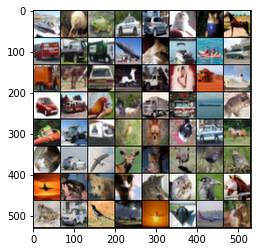

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.imshow(mpimg.imread('./results/real_samples_000.png'),interpolation= 'lanczos')
plt.show()

* Epoch 0

Let's watch the progression.

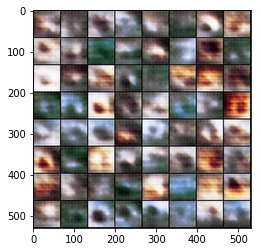

In [4]:
plt.imshow(mpimg.imread('./results/fake_samples_epoch_000.png'),interpolation= 'lanczos')
plt.show()

* Epoch 1

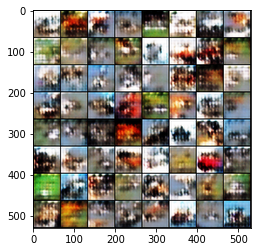

In [5]:
plt.imshow(mpimg.imread('./results/fake_samples_epoch_001.png'),interpolation= 'lanczos')
plt.show()

* Epoch 2

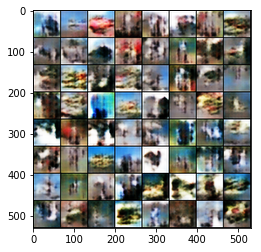

In [6]:
plt.imshow(mpimg.imread('./results/fake_samples_epoch_002.png'),interpolation= 'lanczos')
plt.show()

* Epoch 3

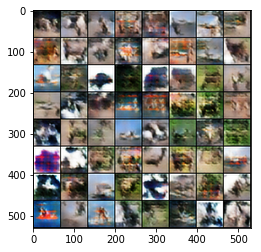

In [7]:
plt.imshow(mpimg.imread('./results/fake_samples_epoch_003.png'),interpolation= 'lanczos')
plt.show()

* Epoch 4

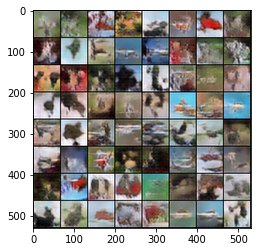

In [8]:
plt.imshow(mpimg.imread('./results/fake_samples_epoch_004.png'),interpolation= 'lanczos')
plt.show()

* Epoch 5

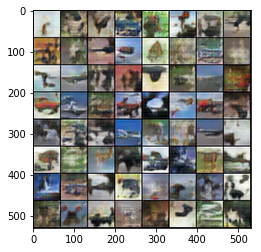

In [9]:
plt.imshow(mpimg.imread('./results/fake_samples_epoch_005.png'),interpolation= 'lanczos')
plt.show()

* Epoch 6

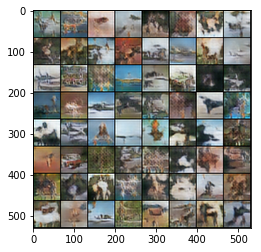

In [10]:
plt.imshow(mpimg.imread('./results/fake_samples_epoch_006.png'),interpolation= 'lanczos')
plt.show()

* Epoch 7

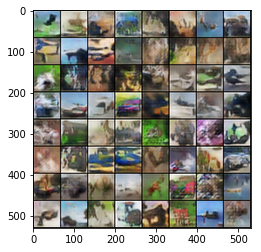

In [11]:
plt.imshow(mpimg.imread('./results/fake_samples_epoch_007.png'),interpolation= 'lanczos')
plt.show()

* Epoch 8

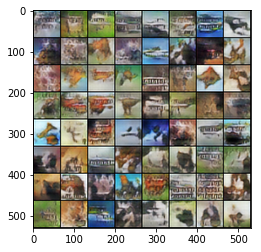

In [12]:
plt.imshow(mpimg.imread('./results/fake_samples_epoch_008.png'),interpolation= 'lanczos')
plt.show()

* Epoch 9

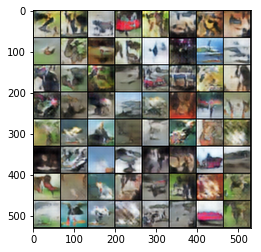

In [13]:
plt.imshow(mpimg.imread('./results/fake_samples_epoch_009.png'),interpolation= 'lanczos')
plt.show()

* Epoch 10

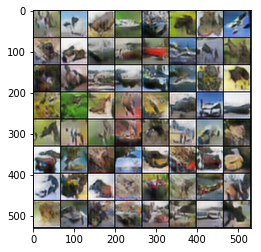

In [14]:
plt.imshow(mpimg.imread('./results/fake_samples_epoch_010.png'),interpolation= 'lanczos')
plt.show()